## GA Placement and Random Backup Allocation (GAPA-RABA)

In [2]:
#libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import pygad

# Dataset

In [3]:
# number of categories 
M = 3
# w_i for each node in category c_i
w = [5, 4, 1]
# price of each active node in category c_i  
pa = [25, 20, 5]
# price of each standby node in category c_i 
ps = [2.5, 2, 0.5]
# failure rate of each active node in category c_i 
fa = [0.008, 0.01, 0.04]
# failure rate of each standby node in category c_i 
fs = [0.0008, 0.001, 0.004]

# total number of nodes
N = 800
# M_i for each category c_i
Mi = [200, 300, 300] 

# parameter of SFC
K = 10
Nk = [5, 5, 5, 5, 3, 2, 5, 3, 2, 5]
Lk = [[10, 20, 5, 6, 9], [1, 1, 1, 1, 1], [20, 40, 50, 45, 45], [10, 20, 25, 25, 20], [3, 4, 8], [2, 2], [10, 20, 5, 6, 9], [3, 4, 8], [2, 2], [20, 40, 50, 45, 45]]
Rk = [0.99, 0.999, 0.9999, 0.9999, 0.99999, 0.99, 0.99999, 0.9999, 0.999999, 0.999]
Tk = [80, 10, 100, 100, 5, 8, 80, 5, 8, 100]
Bk = [1, 3, 4, 1, 2, 3, 2, 2, 4, 1]

# paramete of model
t0 = 1
alpha, beta = 0.65, 0.35

In [4]:
min_time, max_time = 128.6, 417.7
min_price, max_price = 616.5, 3478.5 

# Functions

basic reliability functions

In [17]:
# hot reliability
def get_VNF_reliability_share_hot(vnf, backup, fa):
    theta = math.exp(-1 * fa * t0)
    r = 0
    n = vnf + backup
    for j in range(vnf, n + 1):
        r += (fact(n) / fact(j) / fact(n - j) * pow (theta, j) * pow (1 - theta, n - j))
    return r

def get_VNF_reliability_dedicated_hot(backup, fa):
    theta = math.exp(-1 * fa * t0)
    return 1 - pow(1 - theta, backup + 1)
    
    
# warm reliability
def get_VNF_reliability_share_warm(vnf, backup, fa, fs):
    na = backup + vnf * fa / fs 
    pa = math.exp(-1 * fs * t0)
    x = pow(pa, na)
    r = x
    y = (1 - pa) / pa
    for i in range(1, backup + 1):
        x = x * y * (na - i + 1) / i 
        r += x
    return r

def get_VNF_reliability_dedicated_warm(backup, fa, fs):
    na = backup + 1 * fa / fs 
    pa = math.exp(-1 * fs * t0)
    x = pow(pa, na)
    r = x
    y = (1 - pa) / pa
    for i in range(1, backup + 1):
        x = x * y * (na - i + 1) / i 
        r += x
    return r


# to find factorial of n
def fact(n):
    res = 1
    for i in range(2, n + 1):
        res *= i
    return res

Middle functions in GA - fitness function

In [18]:
# find free capacity of each category
def get_capacity(solution):
    capacity = []
    for i in range(M):
        capacity.append(Mi[i])
        
    for i in range(len(solution)):
        for m in range(M):
            if solution[i] == w[m]:
                capacity[m] -= 1
                break
    return capacity
#############################################################################################

# find execution of each SFC
def get_execution(solution):
    exe = []
    i = 0
    
    for k in range(K):
        time = 0
        for j in range(Nk[k]):
            time += Lk[k][j] / solution[i]
            i += 1
        exe.append(time)
        
    return np.array(exe)
#############################################################################################
  
# find start of each SFC in solution
def get_start():
    start = [0]
    for k in range(1, K):
        start.append(start[k - 1] + Nk[k - 1])
    
    return np.array(start)
#############################################################################################

# find the primary price of solution
def get_primary_price(cpu):
    price = 0
    for i in range(M):
        for j in range(len(cpu)):
            if cpu[j] == w[i]:
                price += pa[i]
    
    return price
#############################################################################################

Dedicated mode - middle function in GA

In [25]:
# find number of backup for SFC that can garantee reliability with finite capacity
def get_backup_random_dedicated_hot(reliability, cpu, capacity):
    # get class of each vnf and allocate 0 backup to each of them
    vnf_class = []
    backup = []
    for j in range(len(cpu)):
        backup.append(0)
        for i in range(M):
            if cpu[j] == w[i]:
                vnf_class.append(i)
                break
    vnf_class = np.array(vnf_class)
    
    # find reliability
    r = 1
    for j in range(len(cpu)):
        r *= get_VNF_reliability_dedicated_hot(backup[j], fa[vnf_class[j]])
        
    # we use the used[] to check capacity
    used = []
    for i in range(len(capacity)):
        used.append(0)
        
    # add backup to garantee reliability
    while r < reliability:
        available_vnf = []
        for j in range(len(cpu)):
            if capacity[vnf_class[j]] - used[vnf_class[j]] > 0:
                available_vnf.append(j)
                
        # we don't have any capacity and reliability is not enough
        if len(available_vnf) == 0:
            for j in range(len(cpu)):
                backup[j] = 3000
            break
            
        # find a random vnf and add a backup for that vnf
        index = random.randint(0, len(available_vnf) - 1)
        backup[available_vnf[index]] += 1
        
        # find reliability
        r = 1
        for j in range(len(cpu)):
            r *= get_VNF_reliability_dedicated_hot(backup[j], fa[vnf_class[j]])
            
        # update capacity
        used[vnf_class[available_vnf[index]]] += 1
    
    
    return np.array(backup)
#############################################################################################

def get_backup_random_dedicated_warm(reliability, cpu, capacity):
    # get class of each vnf and allocate 0 backup to each of them
    vnf_class = []
    backup = []
    for j in range(len(cpu)):
        backup.append(0)
        for i in range(M):
            if cpu[j] == w[i]:
                vnf_class.append(i)
                break
    vnf_class = np.array(vnf_class)
    
    # find reliability
    r = 1
    for j in range(len(cpu)):
        r *= get_VNF_reliability_dedicated_warm(backup[j], fa[vnf_class[j]], fs[vnf_class[j]])
        
    # we use the used[] to check capacity
    used = []
    for i in range(len(capacity)):
        used.append(0)
        
    # add backup to garantee reliability
    while r < reliability:
        available_vnf = []
        for j in range(len(cpu)):
            if capacity[vnf_class[j]] - used[vnf_class[j]] > 0:
                available_vnf.append(j)
                
        # we don't have any capacity and reliability is not enough
        if len(available_vnf) == 0:
            for j in range(len(cpu)):
                backup[j] = 3000
            break
            
        # find a random vnf and add a backup for that vnf
        index = random.randint(0, len(available_vnf) - 1)
        backup[available_vnf[index]] += 1
        
        # find reliability
        r = 1
        for j in range(len(cpu)):
            r *= get_VNF_reliability_dedicated_warm(backup[j], fa[vnf_class[j]], fs[vnf_class[j]])
            
        # update capacity
        used[vnf_class[available_vnf[index]]] += 1
    
    
    return np.array(backup)

Shared mode - minddle function in GA

In [26]:
# find number of backup for SFC that can garantee reliability with finite capacity
def get_backup_random_share_hot(reliability, cpu, capacity):
    # get the number of vnf in each class
    vnf_class = []
    backup = []
    for i in range(M):
        vnf_class.append(0)
        backup.append(0)
        for j in range(len(cpu)):
            if cpu[j] == w[i]:
                vnf_class[i] += 1
    vnf_class = np.array(vnf_class)
    
    # find reliability
    r = 1
    for i in range(M):
        if vnf_class[i] > 0:
            r *= get_VNF_reliability_share_hot(vnf_class[i], backup[i], fa[i])
        
    # we use the used[] to check capacity
    used = []
    for i in range(M):
        used.append(0)
        
    # add backup to garantee reliability
    while r < reliability:
        available_class = []
        for i in range(M):
            if (vnf_class[i] > 0) and (capacity[i] - used[i] > 0):
                available_class.append(i)
                
        # we don't have any capacity and reliability is not enough
        if len(available_class) == 0:
            for i in range(M):
                backup[i] = 3000
            break
            
        # find a random vnf class and add a backup for that 
        index = random.randint(0, len(available_class) - 1)
        backup[available_class[index]] += 1
        
        # find reliability
        r = 1
        for i in range(M):
            if vnf_class[i] > 0:
                r *= get_VNF_reliability_share_hot(vnf_class[i], backup[i], fa[i])

        # update capacity
        used[available_class[index]] += 1
    
    
    return np.array(backup)
#############################################################################################

def get_backup_random_share_warm(reliability, cpu, capacity):
    # get the number of vnf in each class
    vnf_class = []
    backup = []
    for i in range(M):
        vnf_class.append(0)
        backup.append(0)
        for j in range(len(cpu)):
            if cpu[j] == w[i]:
                vnf_class[i] += 1
    vnf_class = np.array(vnf_class)
    
    # find reliability
    r = 1
    for i in range(M):
        if vnf_class[i] > 0:
            r *= get_VNF_reliability_share_warm(vnf_class[i], backup[i], fa[i], fs[i])
        
    # we use the used[] to check capacity
    used = []
    for i in range(M):
        used.append(0)
        
    # add backup to garantee reliability
    while r < reliability:
        available_class = []
        for i in range(M):
            if (vnf_class[i] > 0) and (capacity[i] - used[i] > 0):
                available_class.append(i)
                
        # we don't have any capacity and reliability is not enough
        if len(available_class) == 0:
            for i in range(M):
                backup[i] = 3000
            break
            
        # find a random vnf class and add a backup for that 
        index = random.randint(0, len(available_class) - 1)
        backup[available_class[index]] += 1
        
        # find reliability
        r = 1
        for i in range(M):
            if vnf_class[i] > 0:
                r *= get_VNF_reliability_share_warm(vnf_class[i], backup[i], fa[i], fs[i])

        # update capacity
        used[available_class[index]] += 1
    
    
    return np.array(backup)

fitness function

In [27]:
best_fit = []
best_fit.append(-99999999999999)
price_fit = []
price_fit.append(0)
time_fit = []
time_fit.append(0)

In [28]:
def fitness_function(ga_instance, solution, solution_idx):
     # CHECK FOR EXECUTION TIME
    execution_time = get_execution(solution)
    total_execution_time = np.sum(execution_time)
    
    penalty = 0
    for k in range(K):
        if execution_time[k] > Tk[k]:
            penalty += 1
    
    # CHECK FOR RELIABILITY
    # get free capacity of each class of servers
    capacity = get_capacity(solution)
    
    # make a random priority for SFCs
    priority = np.random.permutation(K)
    start = get_start()
    
    # allocationg backup in a random increasment
    backup_price = 0
    for k in range(K):
        # get SFC and its resource
        sfc = priority[k]
        cpu = []
        for i in range(start[sfc], start[sfc] + Nk[sfc]):
            cpu.append(solution[i])
            
        # get suitable backup for sfc based on its strategy and then update capacity and also find backup price 
        if Bk[k] == 1:
            backup = get_backup_random_dedicated_hot(Rk[sfc], cpu, capacity)
            for i in range(M):
                for j in range(Nk[sfc]):
                    if cpu[j] == w[i]:
                        capacity[i] -= backup[j]
                        backup_price += pa[i] * backup[j]
        elif Bk[k] == 2:
            backup = get_backup_random_dedicated_warm(Rk[sfc], cpu, capacity)
            for i in range(M):
                for j in range(Nk[sfc]):
                    if cpu[j] == w[i]:
                        capacity[i] -= backup[j]
                        backup_price += ps[i] * backup[j]
        elif Bk[k] == 3:
            backup = get_backup_random_share_hot(Rk[sfc], cpu, capacity)
            for i in range(M):
                capacity[i] -= backup[i]
                backup_price += pa[i] * backup[i]
        else:
            backup = get_backup_random_share_warm(Rk[sfc], cpu, capacity)
            for i in range(M):
                capacity[i] -= backup[i]
                backup_price += ps[i] * backup[i]
            
        # CHECK FOR COST(PRICE)
        if backup[0] == 3000:
            penalty += 1
            continue
            
    # get primary price
    primary_price = get_primary_price(solution)
    
    # MAKE FITNESS
    # price
    fitness = alpha * ((primary_price + backup_price - min_price) / (max_price - min_price))
    # execution time
    fitness += beta * ((total_execution_time - min_time) / (max_time - min_time))
    # not good event
    fitness += 1e9 * penalty
    # make fitness negative, because pygad wants to maximize result 
    fitness = -1 * fitness

    if fitness > best_fit[0]:
        best_fit [0] = fitness
        price_fit[0] = primary_price + backup_price
        time_fit[0] = total_execution_time
    
    return fitness

Make a GA instance

In [29]:
# to print result in each generation

a = []
 
def on_generation(ga_instance):
    global last_fitness
    print(f"Generation = {ga_instance.generations_completed}")
    print(f"Fitness    = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]}")
    a.append(ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1])
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]

Generation = 1
Fitness    = -0.29183318443392003
Generation = 2
Fitness    = -0.26873660116784515
Generation = 3
Fitness    = -0.2560662551628334
Generation = 4
Fitness    = -0.23452325961120335
Generation = 5
Fitness    = -0.22739044894865174
Generation = 6
Fitness    = -0.20176889965025557
Generation = 7
Fitness    = -0.20176889965025557
Generation = 8
Fitness    = -0.19315504743630743
Generation = 9
Fitness    = -0.19315504743630743
Generation = 10
Fitness    = -0.19186266820980608
Generation = 11
Fitness    = -0.19186266820980608
Generation = 12
Fitness    = -0.19186266820980608
Generation = 13
Fitness    = -0.19186266820980608
Generation = 14
Fitness    = -0.18593704262076505
Generation = 15
Fitness    = -0.18593704262076505
Generation = 16
Fitness    = -0.18593704262076505
Generation = 17
Fitness    = -0.17775243949692304
Generation = 18
Fitness    = -0.17457377542922797
Generation = 19
Fitness    = -0.17457377542922797
Generation = 20
Fitness    = -0.1528989489055047
Generation 

/home/negin/my_jupyter_env/my_env/lib/python3.12/site-packages/pygad/visualize/plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


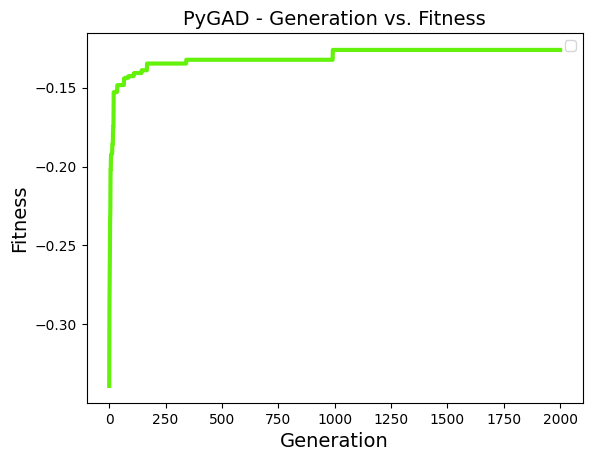

Best solution: [4. 4. 1. 1. 5. 1. 1. 1. 1. 4. 5. 5. 5. 5. 5. 4. 4. 4. 4. 4. 4. 4. 4. 1.
 1. 1. 4. 4. 4. 4. 5. 5. 4. 1. 1. 4. 4. 4. 4. 4.] with fitness: -0.12610289203269695


Best solution: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 5. 5. 5. 1. 1. 1. 1. 1. 5. 5. 5. 1.
 1. 1. 1. 1. 1. 1. 5. 5. 5. 1. 1. 1. 1. 5. 5. 5. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 5. 5. 5. 1. 1. 1. 1. 1. 5. 5. 5.] with fitness: -691.7


In [30]:
num_genes = 40

ga_instance = pygad.GA(
    num_generations = 2000,
    # number of population
    sol_per_pop = 400,
    # number of gen in each chromosome
    num_genes = num_genes,
    # gens
    gene_space = w,
    
    # number of crossover in each generation
    num_parents_mating = 300,
    crossover_type = "two_points",
    # selection
    parent_selection_type = "tournament",
    keep_elitism = 180,
    
    mutation_type = "swap",
    mutation_percent_genes = 10,
    
    random_seed = 3563,
    fitness_func = fitness_function,
    on_generation = on_generation
)

ga_instance.run()
ga_instance.plot_fitness()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Best solution: {solution} with fitness: {solution_fitness}")

/tmp/ipykernel_5123/977942639.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title = "best fitness per generation")


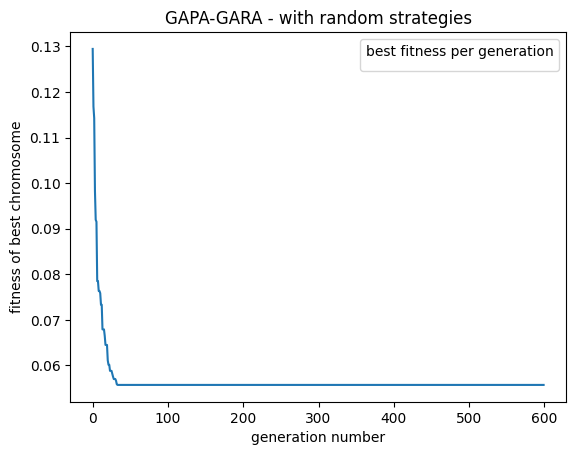

In [14]:
b = []
c = []
for i in range(600):
    b.append(i)
    c.append(-a[i])


plt.legend(title = "best fitness per generation")
plt.title("GAPA-GARA - with random strategies")
plt.xlabel("generation number")
plt.ylabel("fitness of best chromosome")
plt.plot(b, c, '-')
plt.show()

In [15]:
z = random.randint(0, 3)
z

3

In [16]:
print(price_fit[0])
print(time_fit[0])
print(best_fit)

774.5
145.0
[np.float64(-0.05573871875438873)]
